
# Coop@home Biersortiment


## Inhalt
1. [Datenaufbereitung](#sec:daten-aufbereitung)
2. [Das günstigste und das teuerste Bier](#sec:bier-preis)
3. [Welche Biere werden (höher) bewertet?](#sec:ratings)
4. [Zusammenfassung](#sec:summary)

Zuerst werden die Python Packages geladen, die zum Aufbereiten und Darstellen des Datensatzes gebraucht werden.

In [1]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Datenaufbereitung <a class="anchor" id="sec:daten-aufbereitung"></a>

Der Datensatz ist das [Biersortiment des coop@home Onlineshops], besucht mit Firefox am 12.04.2018 und abgespeichert im Ordner `./data` als HTML-Dokument. Wir schauen zuerst kurz im Terminal wie das Dokument aussieht:

[Biersortiment des coop@home Onlineshop]: https://www.coopathome.ch/de/supermarkt/getr%c3%a4nke/bier/c/m_0260?lang=de 


In [2]:
! head -5 data/beers.html

<!DOCTYPE html>
<html class=" js svg cssgradients no-touchevents boxshadow flexbox flexboxlegacy csstransforms csstransitions csshyphens" style="" lang="de">

<head>
    <meta charset="utf-8">


Wie lange ist das ganze Dokument?

In [3]:
! wc -l data/beers.html | sed 's/data\/beers\.html/Zeilen/'

16764 Zeilen


Weitere Inspektion in einem Editor ergibt, dass die Daten zu den Bieren in Tags eingeschlossen sind, die zum Beispiel so aussehen `<li class="list-page__item" data-productid="3494637">...</li>`. Wir lesen das HTML-File mit dem Python Package `BeautifulSoup`, und speichern alle `<li>` elemente mit einer `data-productid` als Beautiful Soup Objekt `products`.

In [4]:
soup = BeautifulSoup(open("./data/beers.html"), 'html.parser')

In [5]:
products = soup.find_all('li', {"data-productid" : re.compile(".*")})


Wir definieren eine Funktion, um die HTML-Daten in einen dictionary zu lesen. Uns interessieren folgende Werte:
- ID 
- Name des Produktes 
- Preis
- Preis pro 100cl 
- Kundenbewertung

In [8]:
def read_data_into_dictionary(products):
    # Funktion liest Produktdaten in einen dictionary.
    datadix = {}
    for res in products:
        data = {}
        product_name = res.img["alt"]
        data["product_name"] = product_name
        if res.dd:
            data["price"] = float(res.dd.get_text())
        else:
            data["price"] = None
        price_per_100 = res.find_all('dd',
                      class_="product-item__price__value product-item__price__value--weight")
        if len(price_per_100) != 0:
            pph = price_per_100[0].get_text()
            #print(pph)
            price_per_100 = re.search("\d+\.\d+\/", pph).group(0)
            price_per_100 = float(price_per_100.replace("/", ""))
        else:
            price_per_100 = None
        data["price_per_100cl"] = price_per_100
        rating_raw = res.find_all('div', class_="product-item__rating")[0].get_text()
        rating_available = re.search("\d\.\d", rating_raw)
        if rating_available:
            rating = float(rating_available.group(0))
        else:
            rating = None
        data["rating"] = rating
        datadix[res['data-productid']] = data
    print("%s Bier-Produkte eingelesen." %str(len(datadix)))
    return datadix

In [9]:
datadix = read_data_into_dictionary(products)

275 Bier-Produkte eingelesen.


Für die weitere Bearbeitung lesen wir alle Daten in eine Pandas DataFrame, und sortieren die Produkte nach der Spalte "Preis pro 100cl".


In [10]:
beerdf = pd.DataFrame(columns=['Name', 'Preis','Preis pro 100cl', 'Rating'])

for item in datadix:
    d = datadix[item]
    beerdf.loc[item] = [d['product_name'], d['price'],
                        d['price_per_100cl'], d['rating']]
    
beerdf = beerdf.sort_values("Preis pro 100cl", ascending=False)

## 2. Das günstigste und das teuerste Bier <a class="anchor" id="sec:bier-preis"></a>
Nachdem alle Daten in einer DatenFrame sind, schauen wir, ob beim Einlesen Fehler passiert sind. Dies ist der Anfang der DataFrame:

In [11]:
beerdf.head(10)

,Name,Preis,Preis pro 100cl,Rating
5985477,Brewdog Bierbrauer-Set IPA,64.90,490.00,2
4905491,Maredsous Abteibier Blond & Braun 3x33cl,17.95,18.13,None
5743287,Pilgrim Bier d'Abbaye Triple Ambrée,6.70,17.87,4.5
5743286,Pilgrim Bier d'Abbaye Triple Blonde,6.70,17.87,5
4674019,Seetaler Cidre de Pomme,11.95,15.93,None
6098642,Castelain Bier Cuvée Cascade,10.95,14.60,None
5997354,BFM Bier La Torpille brune 4x33cl,19.20,14.55,None
6099583,BFM Sauerbier Saison Surette,5.30,14.13,None
3528559,Lindemans Bier Pecheresse,3.50,14.00,5
5986337,Chouffe Bier Blonde Big,19.95,13.30,None


Das Bier mit dem höchsten Preis pro Liter von 490 Franken ist gar kein Bier sondern ein Bierbraukit. Wie auch immer dieser Literpreis zustande kam, wir lassen diesen Eintrag weg.

In [12]:
beerdf = beerdf.drop(['5985477'], axis=0)

Die anderen Werte sehen vernünftig aus. Wie steht es mit dem Ende der Tabelle?

In [13]:
beerdf.tail(10)

,Name,Preis,Preis pro 100cl,Rating
3461333,Prix Garantie Lager-Bier 24x50cl,11.7,0.98,5
4097398,Karlovacko Bier 4x5dl 2000 ml,6.0,0.30,3
6125796,Naturaplan Bio Bier Gran Alpin Amber,0.0,0.00,None
5741898,Appenzeller Bier Indian Pale Ale,NaN,NaN,4
4016748,Einsiedler Bio Alpenbier 6x33cl,NaN,NaN,None
3523746,Bitburger Bier 4x50cl,NaN,NaN,3.5
3425999,Kronenbourg Bier 6x50cl,NaN,NaN,None
6045194,Bitburger Drive Bier alkoholfrei 6x33cl,NaN,NaN,None
3882180,Lägere Bräu Bier 8x33cl,NaN,NaN,4.5
5902982,Birra Moretti Siciliana,NaN,NaN,None


Da gibt es einige Dinge zu überprüfen:
1. Für 7 Biere ist kein Preis vorhanden. Wurden die Daten nicht richtig erfasst?
2. Das Gran Alpin Amber ist gratis. Sehr verdächtig!
3. Das Karlovacko hat einen Literpreis von 30 Rappen (obwohl 4x5dl 6 Franken kosten).

1) Nachforschung auf der Coop Website ergeben, dass die Biere ohne Preise zurzeit nicht verfügbar sind. Sie werden daher ausgeschlossen.

![Nicht verfügbar](./figures/appenzeller-ipa.png)

In [15]:
beerdf = beerdf.loc[-pd.isna(beerdf["Preis"])]

2) Was ist mit dem Bier mit dem Preis 0.0 Franken? Wir schauen nach auf der [Coop Website] und finden, dass das Bier tatsächlich gratis ist!

![Gratis Bier](./figures/gran-alpin.png)

Allerdings nur eines pro Bestellung. Das ist schön, aber wir schliessen dieses Produkt trotzdem aus.

[Coop Website]: https://www.coopathome.ch/de/supermarkt/getr%c3%a4nke/bier/helles-bier-%26-lager/flaschen/naturaplan-bio-bier-gran-alpin-amber/p/6125796?lang=de

In [16]:
beerdf = beerdf.loc[np.invert(beerdf["Preis"]==0)]

3) Und das verdächtig günstige Karlovacko? Es stellt sich heraus, dass dies der Preis pro 100 ml ist (und nicht 100 cl). Der Literpreis ist also um einen Faktor 10 zu klein.

![Falsche Einheiten](./figures/karlovacko.png)

Wir korrigieren dies und sortieren noch einmal:

In [17]:
beerdf.at['4097398','Preis pro 100cl'] = 3.0
beerdf = beerdf.sort_values("Preis pro 100cl", ascending=False)

Jetzt sieht es besser aus. Mit einem Preis von knapp unter einem Franken pro Liter ist das "Prix Garantie Lager" das billigste Bier im Sortiment.

In [18]:
beerdf.tail(5)

,Name,Preis,Preis pro 100cl,Rating
3468796,Tell Lager-Bier 15x33cl,7.45,1.51,5
3383551,Tell Lager-Bier 6x50cl,4.45,1.48,4.5
3512178,"Ramseier Suure Apfel-Moscht 6x1,5l",12.30,1.37,5
4290160,Oettinger Bier 8x50cl,4.95,1.24,4.5
3461333,Prix Garantie Lager-Bier 24x50cl,11.70,0.98,5


Das teuerste ist das "Maredsous Abbey Lager & Brown Beer" mit einem Preis von 18.13 Franken pro Liter.

In [19]:
beerdf.head(5)

,Name,Preis,Preis pro 100cl,Rating
4905491,Maredsous Abteibier Blond & Braun 3x33cl,17.95,18.13,None
5743286,Pilgrim Bier d'Abbaye Triple Blonde,6.70,17.87,5
5743287,Pilgrim Bier d'Abbaye Triple Ambrée,6.70,17.87,4.5
4674019,Seetaler Cidre de Pomme,11.95,15.93,None
6098642,Castelain Bier Cuvée Cascade,10.95,14.60,None


Im Durchschnitt kostet das Bier im coop@home Onlineshop 6.76 Fr. pro Liter.

In [21]:
beerdf.mean()

Preis              11.494361
Preis pro 100cl     6.776880
dtype: float64

Wir stellen die ganze Palette an Bieren, die bei coop@home bestellt werden können als Barplot dar.

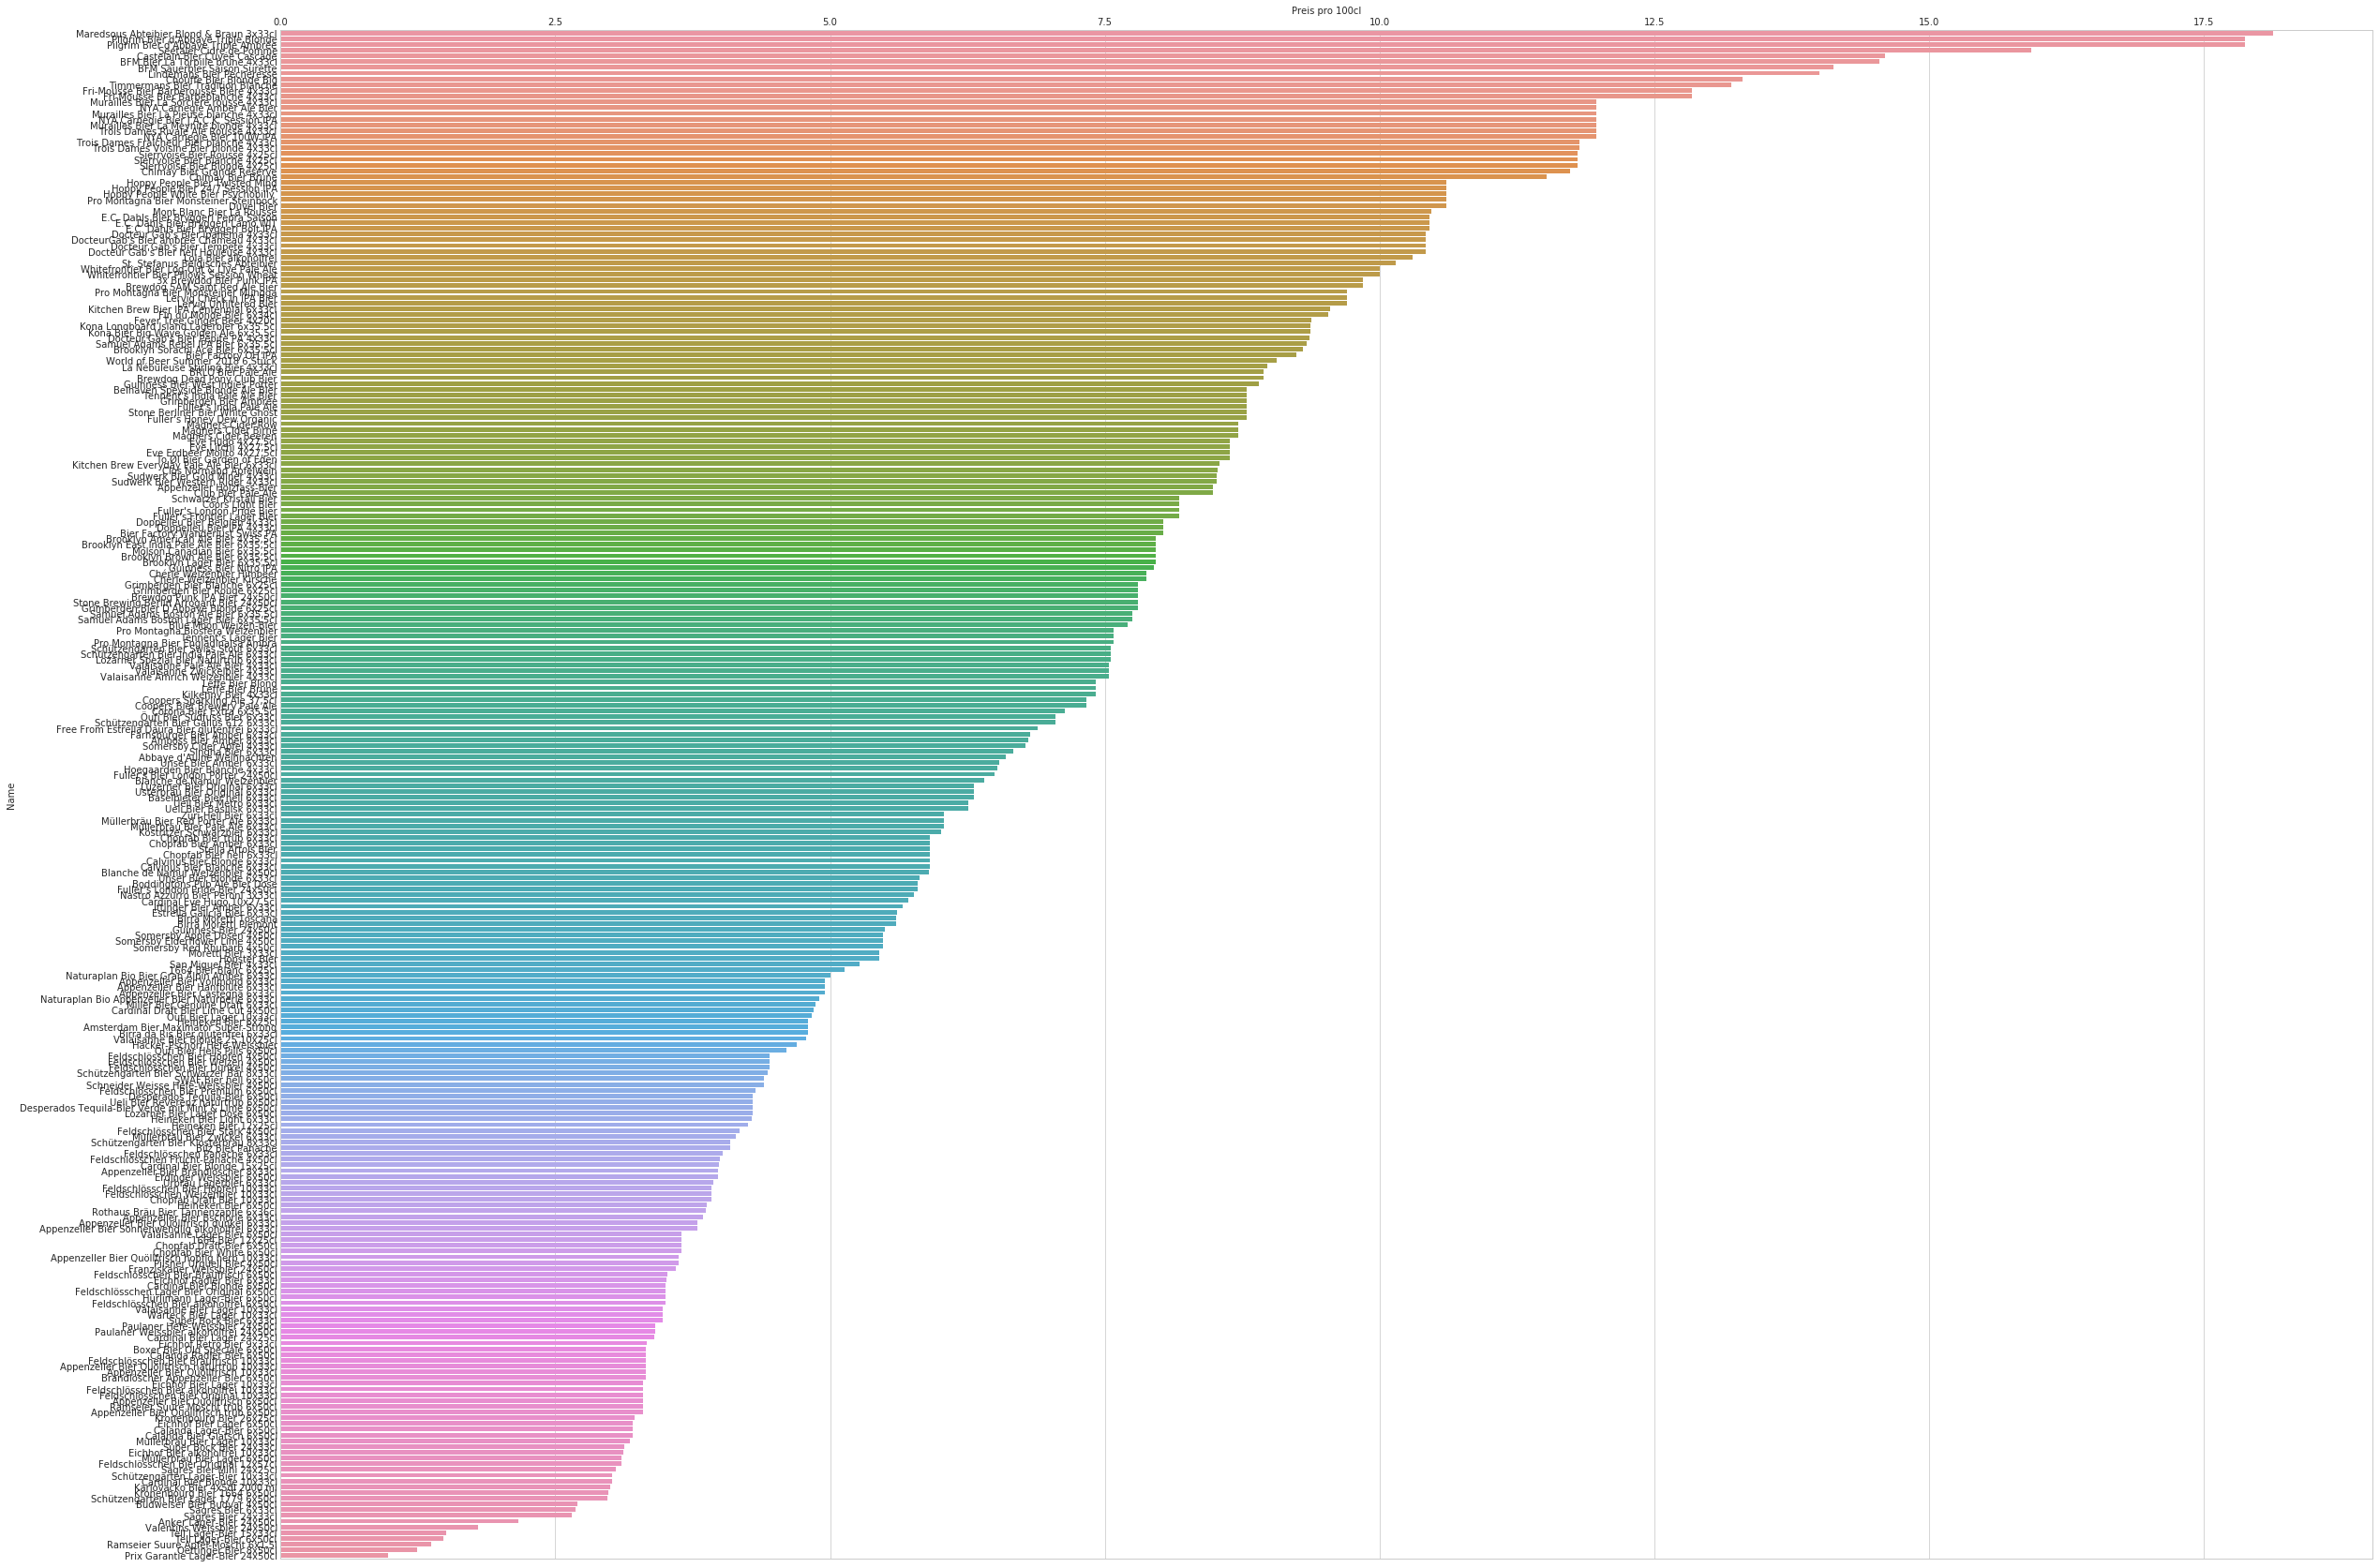

In [24]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots()
    p = sns.barplot(x="Preis pro 100cl", y="Name", data=beerdf,
                 label="Produkt")
fig.set_size_inches(40, 30)
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
# plt.xticks(rotation=90)


## 3. Welche Biere werden (höher) bewertet? <a class="anchor" id="sec:ratings"></a>
Da viele Produkte noch keine oder nur wenige Bewertung haben, ist es schwierig etwas Stichhaltiges zur Beliebtheit der Produkte zu sagen. Die angezeigte Bewertung ist zudem ein gerundeter Durchschnitt von allen Einzelbewertungen, wobei die einzelnen Bewertungen nicht einsehbar sind. Insgesamt haben 198 Bierprodukte mindestens eine Bewertung, und 68 Produkte sind unbewertet.

In [27]:
unbewertet = beerdf[pd.isna(beerdf["Rating"])].shape[0]
bewertet = beerdf[-pd.isna(beerdf["Rating"])].shape[0]

print("%s unbewertet vs. %s bewertet" %(unbewertet,bewertet))

68 unbewertet vs. 198 bewertet


Wie sind die durchschnittlichen Bewertungen verteilt?

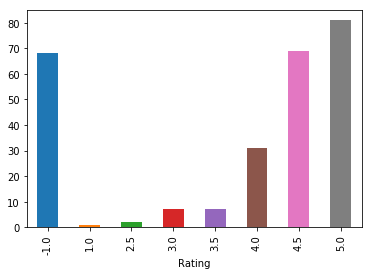

In [28]:
# -1 Für alle Produkte ohne Bewertung
grouped = beerdf.fillna(-1).groupby(["Rating"]).count()
grouped['Name'].plot.bar()

Es fällt auf, dass die meisten bewerteten Produkte eine sehr positive Bewertung haben. 95 Prozent der Produkte sind positiv bewertet, über 90 Prozent haben zwischen 4 und 5 Sterne. Als positive Bewertungen wurden [3.5, 4, 4.5, 5] gezählt, als negativ die Bewertungen [1, 1.5, 2, 2.5], 3 wäre genau in der Mitte. Allerdings kann der Kunde keine halben Sterne verteilen. Und es fragt sich, ob die meisten Kunden eine Bewertung mit 3 Sternen nicht eher als positiv empfinden, da mehr als die Hälfte der Sterne ausgefüllt ist. So gesehen wären 98.5 Prozent der Bewertungen im Schnitt positiv.


In [29]:
pos4_5 = beerdf[beerdf["Rating"].isin([4, 4.5, 5])].shape[0]
pos35_5 = beerdf[beerdf["Rating"].isin([3.5, 4, 4.5, 5])].shape[0]
pos3_5 = beerdf[beerdf["Rating"].isin([3, 3.5, 4, 4.5, 5])].shape[0]
neutral = beerdf[beerdf["Rating"].isin([3])].shape[0]
neg1_25 = beerdf[beerdf["Rating"].isin([1,1.5,2, 2.5])].shape[0]
print("Sehr positiv 4-5:\t %s (%s Prozent)" %(pos4_5, round(pos4_5*100/bewertet,1)))
print("Positiv 3.5-5:\t\t %s (%s Prozent)" %(pos35_5, round(pos35_5*100/bewertet,1)))
print("Oder: positiv 3-5?:\t %s (%s Prozent)" %(pos3_5, round(pos3_5*100/bewertet,1)))
print("Neutral 3:\t\t %s (%s Prozent)" %(neutral, round(neutral*100/bewertet,1)))
print("Negativ 1-2.5:\t\t %s (%s Prozent)" %(neg1_25, round(neg1_25*100/bewertet,1)))

Sehr positiv 4-5:	 181 (91.4 Prozent)
Positiv 3.5-5:		 188 (94.9 Prozent)
Oder: positiv 3-5?:	 195 (98.5 Prozent)
Neutral 3:		 7 (3.5 Prozent)
Negativ 1-2.5:		 3 (1.5 Prozent)


Je nach Interpretation sind also bis zu 98.5 Prozent der Bewertungen positiv. Ist das realistisch? Dazu muss man sich fragen, wer überhaupt Bewertungen abgibt. Erstens sind das wohl Kunden, die mit dem Kaufprozess insgesamt zufrieden waren und sich daher auch gerne noch Zeit nehmen eine Bewertung abzugeben. Zweitens sind das Kunden, die eine ausserordentlich positive oder negative Erfahrung gemacht haben und dies anderen Kunden mitteilen möchten. Doch Bier ist ein Produkt, bei dem man in der Regel ungefähr weiss, was man mag und entsprechend bestellt. Grosse negative Überraschungen gibt es kaum. Aus beiden Gruppen sind also eher positive Bewertungen zu erwarten, und der hohe Anteil an positiven Bewertungen überrascht nicht.


Gibt es irgeneinen Zusammenhang zwischen Preis und Bewertung?

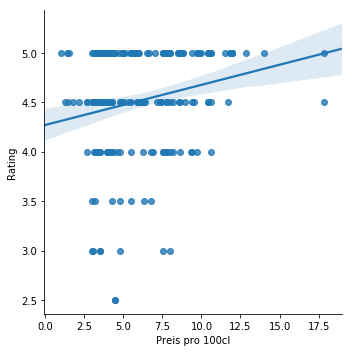

In [30]:
# Es gibt nur eine einzige Bewertung unter 2.5, und wir schliessen diesen Ausreisser aus.
beerdfw = beerdf.drop(['5903430'], axis=0)
sns.lmplot(x="Preis pro 100cl", y="Rating", data=beerdfw)

Es gibt eine leichte Tendenz, dass teurere Biere besser bewertet werden. Weshalb? Vielleicht hat der Kunde bei exklusiven Produkten eher das Bedürfnis mitzuteilen, dass er sie mag. Andererseits ist die teurere Hälfte des Sortiments auch deutlich häufiger nicht bewertet als die billigere Hälfte (rund 4x). Dies wiederum hat vermutlich damit zu tun, dass diese Produkte viel weniger gekauft werden, und deshalb noch keine Bewertungen vorhanden sind. 

In [31]:
unbewertet_teuer = beerdf.head(133)[pd.isna(beerdf["Rating"].head(133))].shape[0]
unbewertet_billig = beerdf.tail(133)[pd.isna(beerdf["Rating"].tail(133))].shape[0]
total_biere = beerdf.shape[0]
print("Unbewertet teurere Hälfte:\t %s (%s Prozent der teureren Hälfte)" 
      %(unbewertet_teuer, round(unbewertet_teuer*100/(total_biere/2),1)))
print("Unbewertet billigere Hälfte:\t %s (%s Prozent der billigeren Hälfte)" 
      %(unbewertet_billig,round(unbewertet_billig*100/(total_biere/2),1))) 

Unbewertet teurere Hälfte:	 53 (39.8 Prozent der teureren Hälfte)
Unbewertet billigere Hälfte:	 15 (11.3 Prozent der billigeren Hälfte)


## 4. Zusammenfassung <a class="anchor" id="sec:summary"></a>

- total bestellbare Bier-Produkte: **266**
- teuerstes Bier-Produkt: **93.60 Fr.** - *Stone Brewing Berlin Arrogant Bier 24x50cl*  - 7.80 Fr. pro Liter.
- billigstes Bier-Produkt: **1.80 Fr.** - *Hopster Bier* - 5.45 Fr. pro Liter. Die ganz günstigen Biere werden online nicht einzeln verkauft.
- maximaler Preis pro Liter: **18.13 Fr. pro Liter** - *Maredsous Abteibier Blond & Braun 3x33cl*.	
- minimaler Preis pro Liter: **0.98 Fr. pro Liter** - *Prix Garantie Lager-Bier 24x50cl*.
- durchschnittlicher Preis pro Liter: **6.77 Fr. pro Liter**
- bewertete Produkte: **198**
- unbewertete Produkte: **68**
- Produkte mit positiver Bewertung (3.5-5): **188** (94.9 Prozent)
- neutrale Bewertung 3 (oder positiv?): **7** (3.5 Prozent)
- Produkte mit negativer Bewertung (1-2.5): **3** (1.5 Prozent)
- die billigere Hälfte des Sortiments hat mehr Bewertungen (**14** unbewertet), da mehr gekauft (?).
- die teurere Hälfte des Sortiments hat weniger Bewertungen (**54** unbewertet), aber tendenziell bessere.